In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
from math import *

from PIL import Image
import scipy
import scipy.misc

import glob
import pickle

import torch
from torch.autograd import Variable, Function
from torch import Tensor
from torch import nn
from torch.nn import functional as F
import torch.optim as optim

#dtype = torch.cuda.FloatTensor

def tovar(x):
    return Variable(torch.FloatTensor(x), requires_grad = False)

def toivar(x):
    return Variable(torch.LongTensor(x), requires_grad = False)

Populating the interactive namespace from numpy and matplotlib


In [2]:
DIM = 32
vects = np.random.randn(2*6,DIM)

def getSample(BS):
    i = np.random.randint(6,size=(BS,))
    y = np.random.randint(2,size=(BS,))
    
    return (vects[i+6*y] + 2*np.random.randn(BS,DIM)), y.astype(np.float32)

In [49]:
HID = 32

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        self.l1 = nn.Linear(DIM,HID)#.cuda()
        self.l2 = nn.Linear(HID,HID)#.cuda()
        self.l3 = nn.Linear(HID,HID)#.cuda()
        self.l4 = nn.Linear(HID,HID)#.cuda()
        self.l5 = nn.Linear(HID,HID)#.cuda()
        self.out = nn.Linear(HID, 1)#.cuda()
        
        self.d1 = nn.Dropout(0.5)
        self.d2 = nn.Dropout(0.5)
        self.d3 = nn.Dropout(0.5)
        self.d4 = nn.Dropout(0.5)
        self.d5 = nn.Dropout(0.5)        
        #self.adam = torch.optim.Adam(self.parameters(), lr=1e-3)
        #self.sgd = torch.optim.SGD(self.parameters(), lr=0.1)
            
    def forward(self, x, label):        
        z1 = self.d1(F.relu(self.l1(x)))
        z2 = self.d2(F.relu(self.l2(z1)))
        z3 = self.d3(F.relu(self.l3(z2)))
        z4 = self.d4(F.relu(self.l4(z3)))                    
        z5 = self.d5(F.relu(self.l5(z4)))
                     
        p = torch.clamp(F.sigmoid(self.out(z5)),1e-6,1-1e-6)
        
        loss = -(label*torch.log(p)+(1.0-label)*torch.log(1.0-p))
        return loss

In [47]:
cls1 = Classifier()
cls2 = Classifier()

In [20]:
from IPython import display
import time

train_x, train_y = getSample(5000)
test_x, test_y = getSample(5000)

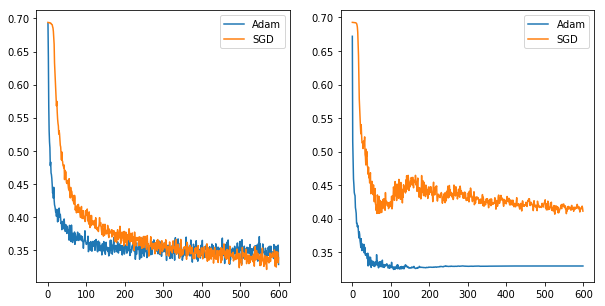

9


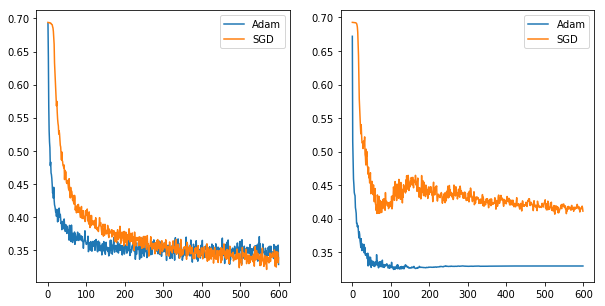

In [73]:
tests1 = []
tests2 = []

for batch in range(10):
    train_err1 = []
    train_err2 = []
    test_err1 = []
    test_err2 = []

    cls1 = Classifier()
    cls2 = Classifier()

    for epoch in range(600):
        BS = 100
        e1 = 0
        e2 = 0
        count = 0

        lr1 = 4e-3*exp(-epoch/50.0)
        lr2 = 0.1*exp(-epoch/200.0)

        adam = torch.optim.Adam(cls1.parameters(), lr = lr1)
        sgd = torch.optim.SGD(cls2.parameters(), lr = lr2)

        cls1.train()
        cls2.train()
        for i in range(train_x.shape[0]//BS):
            cls1.zero_grad()
            cls2.zero_grad()
            loss1 = torch.mean(cls1.forward(tovar(train_x[i*BS:i*BS+BS]), tovar(train_y[i*BS:i*BS+BS])))
            loss2 = torch.mean(cls2.forward(tovar(train_x[i*BS:i*BS+BS]), tovar(train_y[i*BS:i*BS+BS])))
            loss1.backward()
            loss2.backward()

            adam.step()
            sgd.step()
            e1 += loss1.cpu().data.numpy()[0]
            e2 += loss2.cpu().data.numpy()[0]
            count += 1

        train_err1.append(e1 / float(count))
        train_err2.append(e2 / float(count))

        cls1.eval()
        cls2.eval()
        loss1 = torch.mean(cls1.forward(tovar(test_x), tovar(test_y)))
        loss2 = torch.mean(cls2.forward(tovar(test_x), tovar(test_y)))

        test_err1.append(loss1.cpu().data.numpy()[0])
        test_err2.append(loss2.cpu().data.numpy()[0])

        plt.clf()
        plt.subplot(1,2,1)
        plt.plot(train_err1,label="Adam")
        plt.plot(train_err2,label="SGD")
        plt.legend()
        plt.subplot(1,2,2)
        plt.plot(test_err1,label="Adam")
        plt.plot(test_err2,label="SGD")
        plt.legend()
        plt.gcf().set_size_inches((10,5))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.01)
    print(batch)
    tests1.append(test_err1)
    tests2.append(test_err2)

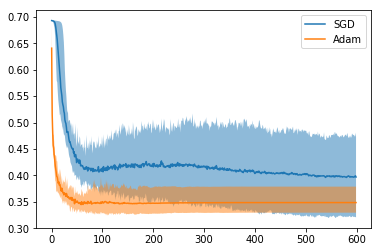

In [74]:
mu1 = np.mean(np.array(tests1),0)
std1 = np.std(np.array(tests1),0)
min1 = np.min(np.array(tests1),0)
max1 = np.max(np.array(tests1),0)

mu2 = np.mean(np.array(tests2),0)
std2 = np.std(np.array(tests2),0)
min2 = np.min(np.array(tests2),0)
max2 = np.max(np.array(tests2),0)

x = np.arange(mu1.shape[0])
plt.plot(x,mu2,label="SGD")
plt.plot(x,mu1,label="Adam")
plt.fill_between(x,max2,min2,alpha=0.5)
plt.fill_between(x,max1,min1,alpha=0.5)
plt.legend()
#for i in range(len(tests1)):
#    plt.plot(tests1[i])
plt.show()

#for i in range(len(tests2)):
#    plt.plot(tests2[i])
#plt.show()